In [1]:
import pandas as pd

df = pd.read_csv("cian_apartments.csv")

In [2]:
total = len(df)

propusk = df.isna().any(axis=1).sum()

print(f"Общее число строк {total}")
print(f"Общее число строк с пропусками {propusk}")

Общее число строк 3495
Общее число строк с пропусками 3254


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

Среднее = 382891.634620887
Удалено записей: 364 (10.41%)


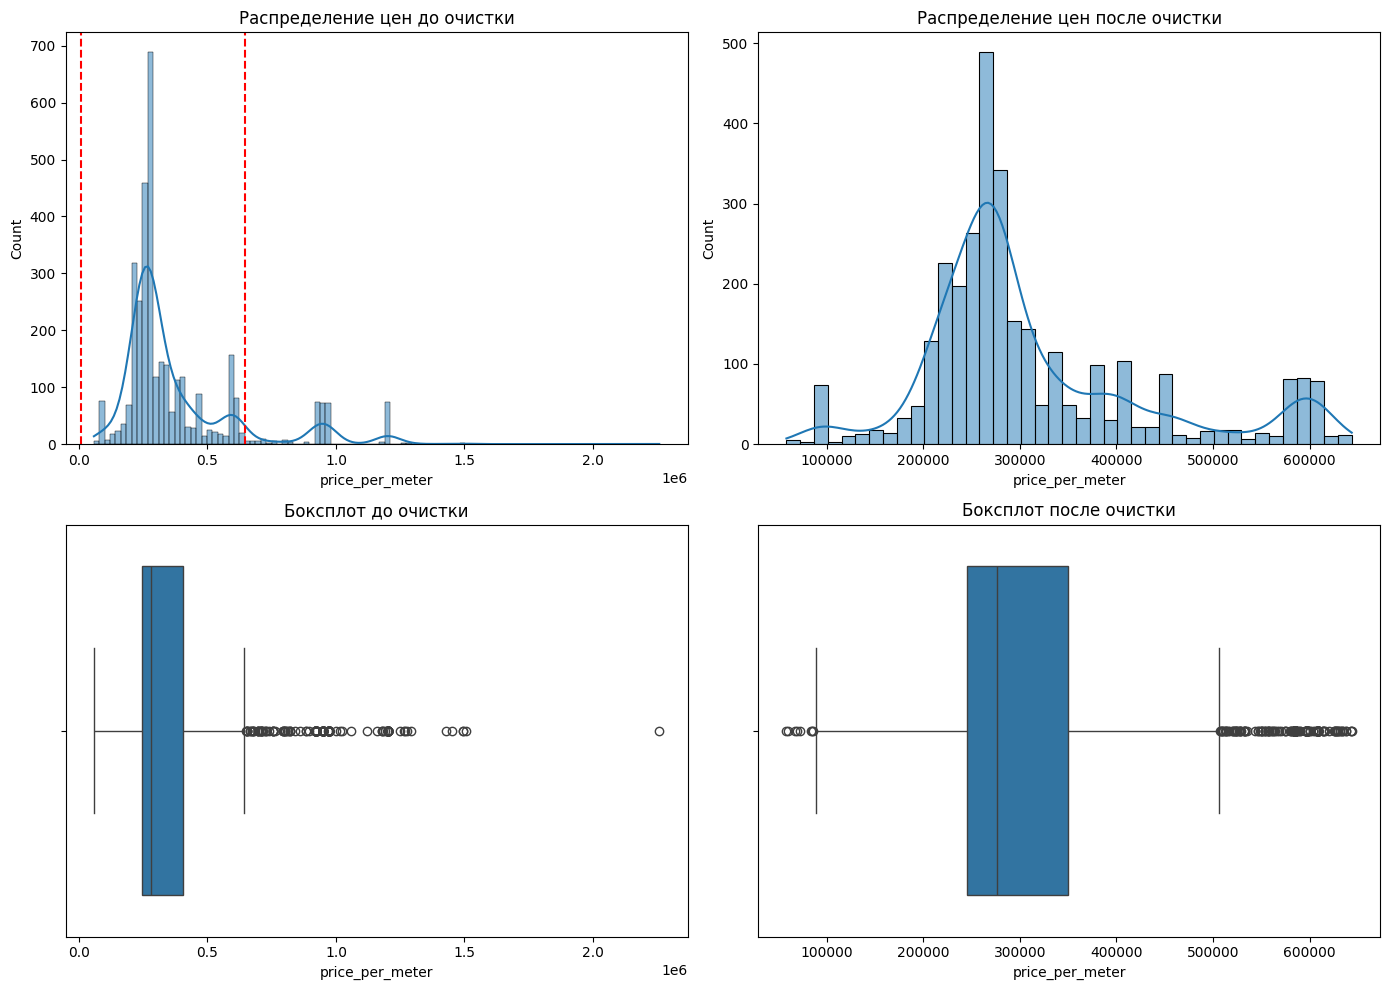

Среднее = 312296.7713190674


In [4]:
print(f"Среднее = {df['price_per_meter'].mean()}")
Q1 = df['price_per_meter'].quantile(0.25) 
Q3 = df['price_per_meter'].quantile(0.75) 
IQR = Q3 - Q1

lower_bound = Q1 - IQR * 1.5
higher_bound = Q3 + IQR * 1.5

df_clean = df[(df['price_per_meter'] >= lower_bound) & (df['price_per_meter'] <= higher_bound)]
print(f"Удалено записей: {len(df) - len(df_clean)} ({(len(df) - len(df_clean)) / len(df) * 100:.2f}%)")

boundaries = (lower_bound, higher_bound)

plt.figure(figsize=(14, 10))


plt.subplot(2, 2, 1)
sns.histplot(df['price_per_meter'], kde=True)
plt.title('Распределение цен до очистки')
plt.axvline(boundaries[0], color='r', linestyle='--')
plt.axvline(boundaries[1], color='r', linestyle='--')

plt.subplot(2, 2, 2)
sns.histplot(df_clean['price_per_meter'], kde=True)
plt.title('Распределение цен после очистки')

plt.subplot(2, 2, 3)
sns.boxplot(x=df['price_per_meter'])
plt.title('Боксплот до очистки')

plt.subplot(2, 2, 4)
sns.boxplot(x=df_clean['price_per_meter'])
plt.title('Боксплот после очистки')

plt.tight_layout()
plt.show()

df_clean.to_csv('cian_apartments_clean_iqr.csv', index=False)

print(f"Среднее = {df_clean['price_per_meter'].mean()}")

In [5]:
df_metro = df_clean.dropna(subset=["minutes_to_metro"])

grouped = df_metro.groupby('minutes_to_metro')['price_per_meter'].mean().reset_index()
grouped = grouped.sort_values('minutes_to_metro')

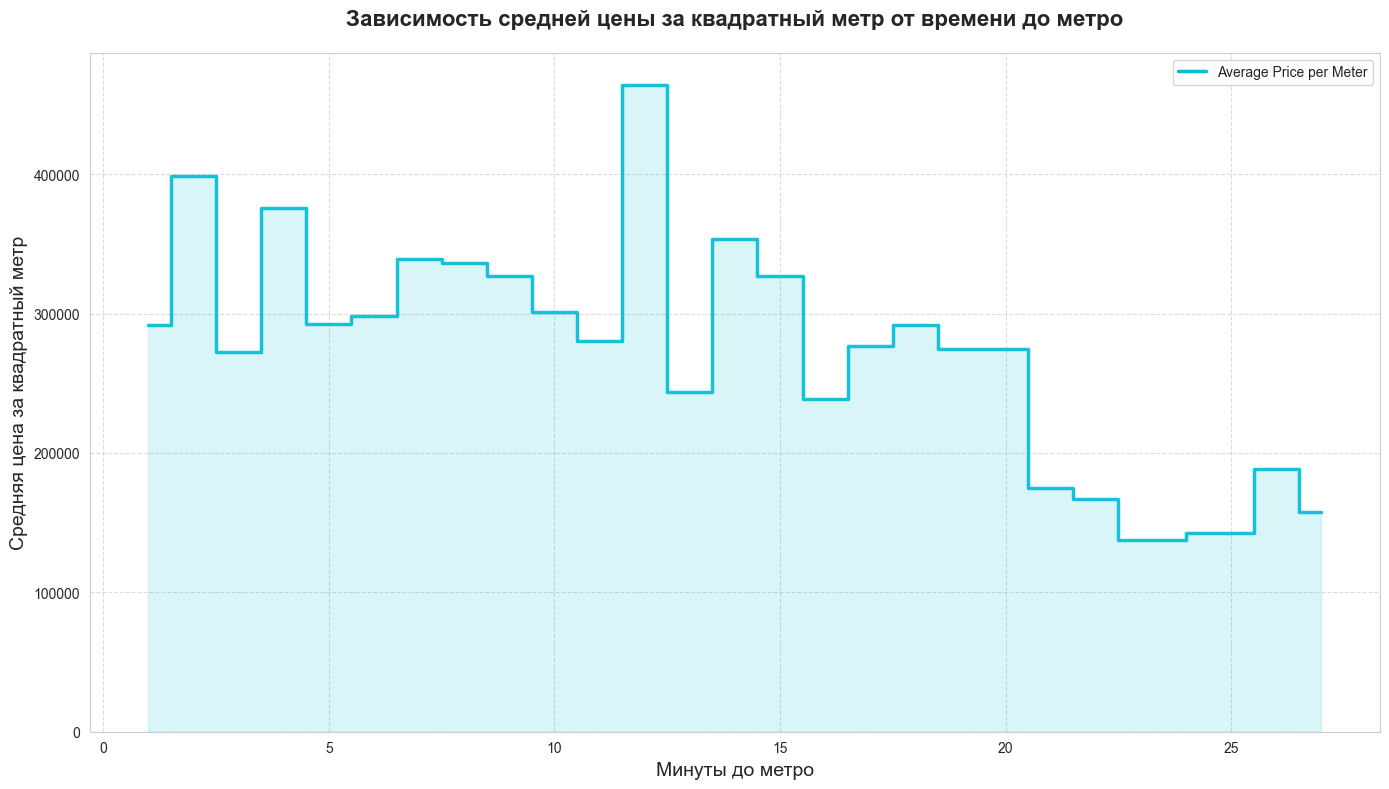

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,8))
plt.step(grouped['minutes_to_metro'], grouped['price_per_meter'], where='mid', color='#00BCD4', linewidth=2.5, alpha=0.9)
plt.fill_between(grouped['minutes_to_metro'], grouped['price_per_meter'], step="mid", alpha=0.15, color='#00BCD4')

plt.title('Зависимость средней цены за квадратный метр от времени до метро', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Минуты до метро', fontsize=14)
plt.ylabel('Средняя цена за квадратный метр', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(bottom=0)

plt.plot([], [], color='#00BCD4', linewidth=2.5, label='Average Price per Meter')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
df_with_renovation = df.dropna(subset=['renovation_type'])

renovation_type_avg = df_with_renovation.groupby('renovation_type')['price_per_meter'].mean().reset_index()
print(f"Количество квартир с данными о ремонте: {len(df_with_renovation)}")

Количество квартир с данными о ремонте: 268


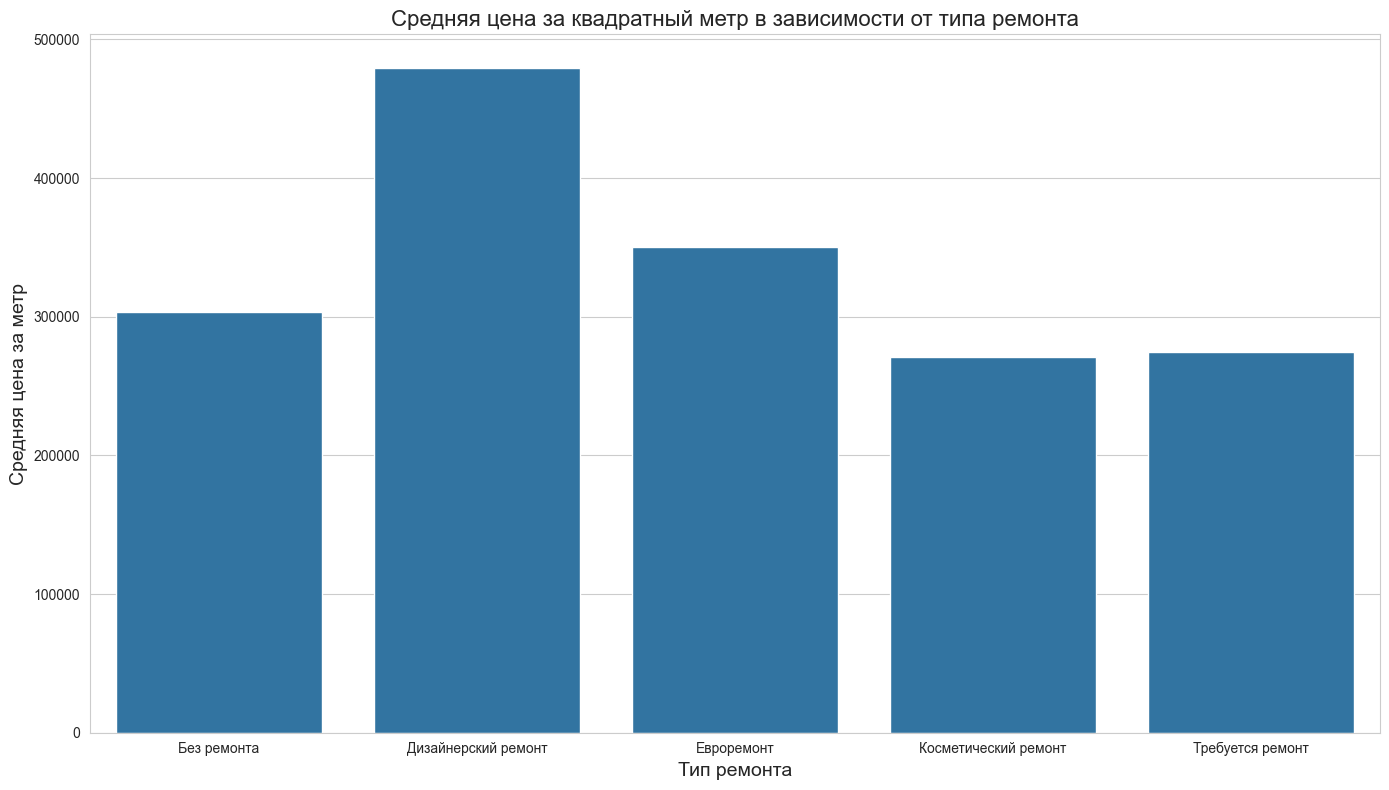

In [8]:
plt.figure(figsize=(14,8))
ax = sns.barplot(x='renovation_type',y='price_per_meter',data=renovation_type_avg)

plt.title('Средняя цена за квадратный метр в зависимости от типа ремонта', fontsize=16)
plt.xlabel('Тип ремонта', fontsize=14)
plt.ylabel('Средняя цена за метр', fontsize=14)

plt.tight_layout()
plt.show()

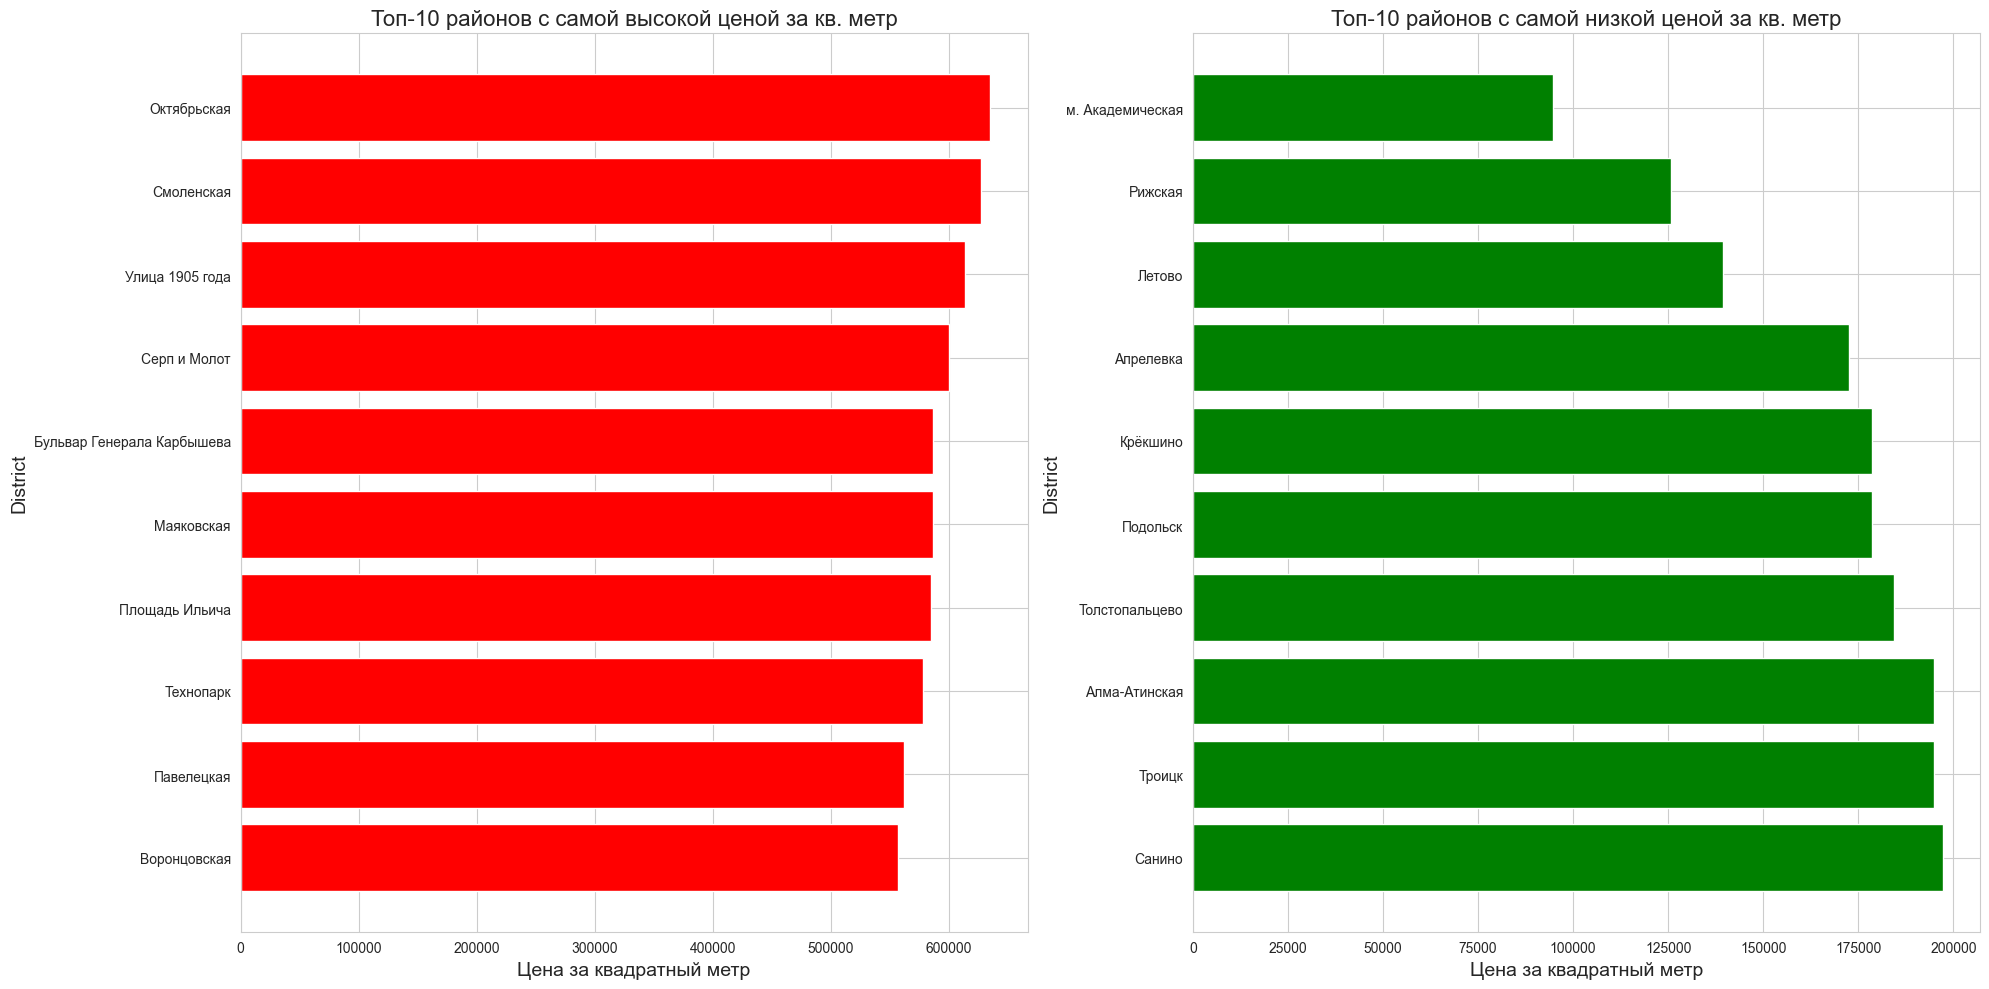

In [9]:
df_districts = df_clean.dropna(subset=['price_per_meter','metro_station'])
df_districts = df_districts[df_districts['price_per_meter'] > 0]

district_prices = df_districts.groupby('metro_station')['price_per_meter'].mean().reset_index()

top_10_expensive = district_prices.sort_values('price_per_meter', ascending=False).head(10)

top_10_cheapest = district_prices.sort_values('price_per_meter').head(10)


plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

plt.subplot(1,2,1)
bars1 = plt.barh(top_10_expensive['metro_station'],top_10_expensive['price_per_meter'], color='red')
plt.title('Топ-10 районов с самой высокой ценой за кв. метр', fontsize=16)
plt.xlabel('Цена за квадратный метр', fontsize=14)
plt.ylabel('District', fontsize=14)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
bars2 = plt.barh(top_10_cheapest['metro_station'],top_10_cheapest['price_per_meter'],color='green')
plt.title('Топ-10 районов с самой низкой ценой за кв. метр', fontsize=16)
plt.xlabel('Цена за квадратный метр', fontsize=14)
plt.ylabel('District', fontsize=14)
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()

Регрессионные модели

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

X = df_clean.drop(['price','link','price_per_meter'],axis=1)
y = df_clean['price']

categorial_features = ['metro_station','renovation_type']
numerical_features = ['square_meters', 'minutes_to_metro']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorial_transformer, categorial_features)
    ])

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'XGBoost': XGBRegressor()
}


In [12]:
res = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
        
    y_pred = pipeline.predict(X_test)
        
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
        
    res[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
        }

res_df = pd.DataFrame(res).T
print(res_df.sort_values('R2', ascending=False))


                            MSE          RMSE           MAE        R2
Extra Trees        4.933009e+12  2.221038e+06  9.594805e+05  0.801329
XGBoost            5.225776e+12  2.285996e+06  1.150651e+06  0.789538
Random Forest      6.041072e+12  2.457859e+06  1.097739e+06  0.756703
Gradient Boosting  6.346294e+12  2.519185e+06  1.549896e+06  0.744410
Ridge              6.632909e+12  2.575443e+06  1.457335e+06  0.732867
Linear Regression  7.293355e+12  2.700621e+06  1.483841e+06  0.706268
Decision Tree      8.317105e+12  2.883939e+06  1.224104e+06  0.665038
AdaBoost           1.519169e+13  3.897652e+06  3.106774e+06  0.388172


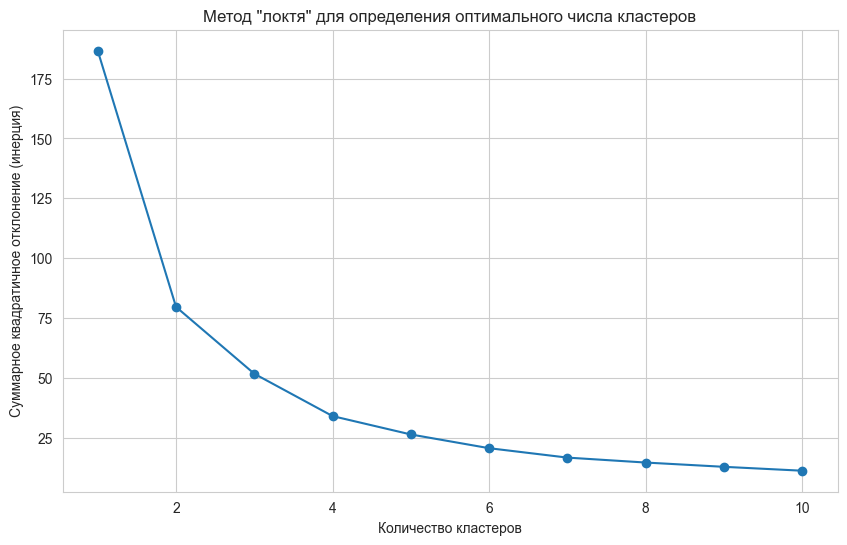

In [13]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

cluster_features = ['price_per_meter', 'square_meters', 'rooms', 'minutes_to_metro']
df_cluster = df.dropna(subset=cluster_features)

scaler = MinMaxScaler()
X_cluster = scaler.fit_transform(df_cluster[cluster_features])

inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'o-')
plt.xlabel('Количество кластеров')
plt.ylabel('Суммарное квадратичное отклонение (инерция)')
plt.title('Метод "локтя" для определения оптимального числа кластеров')
plt.grid(True)
plt.show()

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_cluster)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['cluster'], cmap='viridis', 
           s=50, alpha=0.7, edgecolors='w')
plt.title('Визуализация кластеров квартир с помощью PCA')
plt.colorbar(scatter, label='Номер кластера')
plt.xlabel(f'Главная компонента 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Главная компонента 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
cluster_analysis = df_cluster.groupby('cluster')[cluster_features].mean()
print("Средние значения признаков по кластерам:")
print(cluster_analysis)

Средние значения признаков по кластерам:
         price_per_meter  square_meters  rooms  minutes_to_metro
cluster                                                         
0           3.136629e+05      42.109787    1.0          4.665931
1           3.409290e+05      34.501015    1.0         14.157078
2           1.050311e+06      71.750757    1.0          5.258964
